In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from evaluation import evaluate
from synthetic_data_generator import synthetic_data_generator
from src.algorithms.dagmm import DAGMM
from src.algorithms import RecurrentEBM

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
def binary_label(pred):
    threshold = np.mean(pred) + 2*np.std(pred)
    return np.where(pred >= threshold, 1, 0)

In [5]:
def plot_scores(X_test, pred, scale_factor, threshold = None):
    if threshold:
        threshold_line = len(X_test) * [threshold]
    else:
        threshold_line = len(X_test) * [np.mean(pred) + 2*np.std(pred)]
    #plt.subplot(211)
    for col in X_test.columns:
        plt.plot(X_test[col], color="black")
    #plt.subplot(212)
    plt.plot(np.arange(len(X_test)), [x/scale_factor for x in pred])
    plt.plot([x/scale_factor for x in threshold_line])
    plt.legend()
    plt.title('Reconstruction error DBESM')
    plt.show()

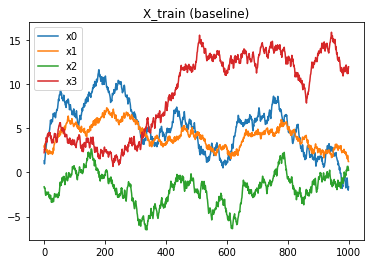

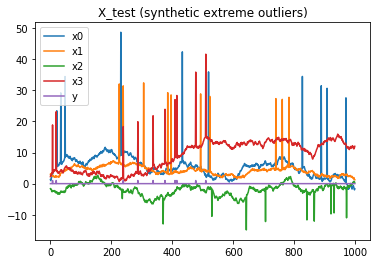

100%|██████████| 15/15 [00:05<00:00,  3.05it/s]


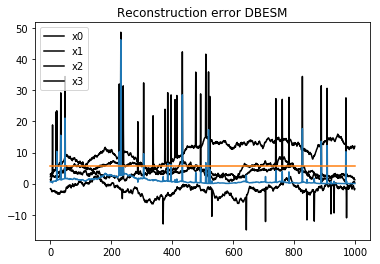

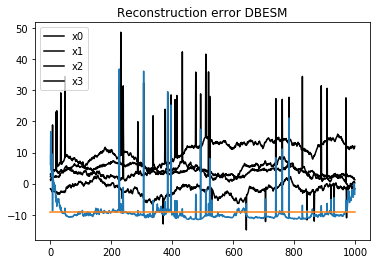

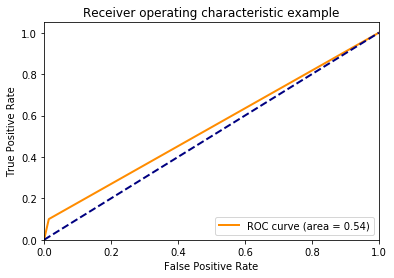

    name  accuracy  precision  recall  F1-score
0  DBESM     0.977   0.066667     0.1      0.08


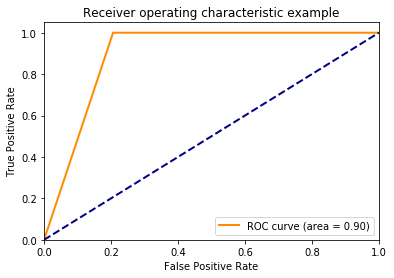

    name  accuracy  precision  recall  F1-score
0  DBESM     0.977   0.066667     0.1  0.080000
1  DAGMM     0.796   0.046729     1.0  0.089286


In [8]:
def main():
    data_generator = synthetic_data_generator()
    X_train, y_train, X_test, y_test = data_generator.generate_outliers("extreme")
    
    y_binary = [] # predicted binary labels of all models
    y_scores = [] # error measures of each prediction
    
    ReEBM = RecurrentEBM(num_epochs=15)
    ReEBM.fit(X_train, None)
    ReEBM_scores = ReEBM.predict(X_test)
    ReEBM_binary = binary_label(ReEBM_scores)
    y_binary.append(ReEBM_binary)
    plot_DBESM_errors(X_test, ReEBM_scores, 100)
    
    dagmm = DAGMM()
    dagmm.fit(X_train.values, y_train)
    dagmm_binary, dagmm_scores, dagmm_threshold = dagmm.predict(X_test.values)
    y_binary.append(dagmm_binary)
    plot_scores(X_test, dagmm_scores, 0.75, dagmm_threshold)
    
    working_models = ["DBESM", "DAGMM"]
    evaluate(y_test.values, y_binary, working_models)

if __name__ == '__main__':
    main()